This notebook is for getting familiar with the LCEGP model.

The goal is to better understand its behavior, in particular how the embedding functions.

We can use a GP model as the function to estimate to see if the embedding recovers the
original sampling locations.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch
from botorch import fit_gpytorch_model
from botorch.models import SingleTaskGP
from botorch.models.transforms import Standardize
from botorch.test_functions import Hartmann
from botorch.utils.transforms import unnormalize
from gpytorch.mlls import ExactMarginalLogLikelihood
from torch import Tensor

from contextual_rs.lce_gp import LCEGP


def generate_random_gp(
    num_train: int,
    dim: int,
    seed: int = None,
) -> SingleTaskGP:
    r"""
    Generate a fitted GP model on random data.
    """
    if seed:
        torch.manual_seed(seed)
    train_x = torch.rand(num_train, dim)
    # train_y = torch.randn(num_train, 1)
    f = Hartmann(dim=4)
    train_y = f(unnormalize(train_x, f.bounds)).view(-1, 1)
    model_ = SingleTaskGP(
        train_X=train_x,
        train_Y=train_y,
        outcome_transform=Standardize(m=1),
    )
    mll_ = ExactMarginalLogLikelihood(model_.likelihood, model_)
    _ = fit_gpytorch_model(mll_)
    return model_


def get_independent_observations(
    X: Tensor,
) -> Tensor:
    r"""
    Generate observations from the given `function_model`, using it as the
    objective function. Observations are generated independently,
    i.e., by ignoring the correlations between the inputs.
    """
    X_ = X.unsqueeze(-2)
    samples_ = function_model.posterior(X_).rsample()
    return samples_.view(samples_.shape[:-2])


def evaluate_with_embedding(
    X: Tensor,
) -> Tensor:
    r"""
    Evaluate the input `X`, which includes the category index
    at the `embedding_col`, by first applying the embedding,
    then calling `get_independent_observations`.
    """
    if embedding_col % X.shape[-1] != X.shape[-1] - 1:
        raise NotImplementedError(
            "This currently only supports embedding indices at the last column."
        )
    emb_idcs = X[..., embedding_col].long()
    embeddings = correct_embedding[emb_idcs].view(*X.shape[:-1], embedding_dim)
    X_ = torch.cat(
        [X[..., :embedding_col], embeddings], dim=-1
    )
    return get_independent_observations(X_)


In [2]:
function_model = generate_random_gp(num_train=100, dim=4, seed=0)
correct_embedding = torch.tensor([
    [0.2, 0.3],  # 0
    [0.3, 0.5],  # 1
    [0.5, 0.9],  # 2
    [0.23, 0.29],  # 3
    [0.9, 0.7],  # 4
    [0.0, 0.0],  # 5
    [1.0, 1.0],  # 6
    [0.5, 0.3],  # 7
    [0.6, 0.2],  # 8
    [0.8, 0.9],  # 9
])
embedding_col = -1
embedding_dim = 2


def train_lcegp(num_train: int) -> LCEGP:
    r"""
    Fits LCEGP using the embedding defined above and given number of samples.
    """
    train_X = torch.cat(
        [
            torch.rand(num_train, 2),
            torch.randint(0, 10, (num_train, 1)),
        ], dim=-1
    )
    train_X[:10, -1] = torch.arange(0, 10)  # ensure all indices appear
    train_Y = evaluate_with_embedding(train_X).view(num_train, 1).detach()

    model_ = LCEGP(
        train_X=train_X,
        train_Y=train_Y,
        categorical_cols=[embedding_col],
        embs_dim_list=[embedding_dim],
        outcome_transform=Standardize(m=1),
    )
    mll = ExactMarginalLogLikelihood(model_.likelihood, model_)
    _ = fit_gpytorch_model(mll)
    return model_


Let's see what the embedding is like, if it resembles the correct one in any way etc.

In [3]:
model = train_lcegp(50)
emb_layer = model.emb_layers[0]
print(emb_layer.weight)

Parameter containing:
tensor([[ 0.5724,  0.8317],
        [ 0.8136,  0.6791],
        [ 1.5252, -1.1715],
        [-2.2641, -2.8864],
        [ 0.3982, -0.7024],
        [-1.7193,  0.3117],
        [ 1.1924, -1.3258],
        [ 0.4259,  0.8872],
        [ 0.1011,  2.2347],
        [ 1.6736, -1.9083]], requires_grad=True)


In [4]:
model = train_lcegp(500)
emb_layer = model.emb_layers[0]
learned = emb_layer.weight
print(learned)

Parameter containing:
tensor([[-1.6995, -1.1689],
        [-0.5259,  0.7041],
        [-0.2511, -0.7732],
        [ 0.9534, -0.1602],
        [-0.4651, -0.8509],
        [ 1.2214, -0.6342],
        [ 1.0379,  1.4321],
        [ 0.9088, -0.1092],
        [-0.1314,  0.7965],
        [-1.7827,  0.8165]], requires_grad=True)


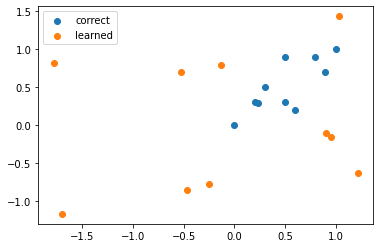

In [5]:
learned = learned.detach()

plt.scatter(correct_embedding[:, 0], correct_embedding[:, 1], label="correct")
plt.scatter(learned[:, 0], learned[:, 1], label="learned")
plt.legend()
plt.show()


It is hard to make sense of these values. Let's plot some sample paths.

Reducing dimension by fixing the first dimension to 0.5.

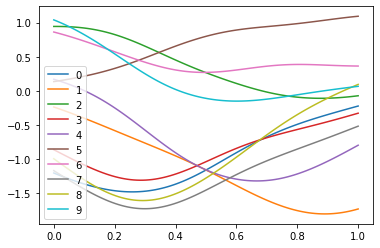

In [6]:
plot_x = torch.cat(
    [
        torch.ones(10, 100, 1) * 0.5,
        torch.linspace(0, 1, 100).unsqueeze(-1).expand(10, -1, -1),
        torch.arange(0, 10, 1).view(10, 1, 1).expand(-1, 100, -1),
    ], dim=-1
)

pm = model.posterior(plot_x).mean.detach()

plt.figure()
for i in range(10):
    plt.plot(torch.linspace(0, 1, 100), pm[i], label=i)
plt.legend()
plt.show()

Some lines appear to show similar to expected correlation structures, though it is
possible that this is simply confirmation bias. An example is lines 6&9.